<a href="https://colab.research.google.com/github/2r4u/fruit-model/blob/main/Fruits_Classification_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# code for run on google colab
!pip install -q kaggle
from google.colab import files
files.upload() #upload kaggle api json file
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d moltean/fruits
!unzip fruits.zip


Streaming output truncated to the last 5000 lines.
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/112_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/113_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/114_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/115_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/116_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/117_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/119_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/120_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/121_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/122_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/123_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/124_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Traini

In [6]:
# Librairies

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

### Exploring the fruits-360 dataset
The dataset is extracted to the directory data/fruits-360. It contains 2 folders (train and test), containing the training set (67,692 images) and test set (22,688 images) respectively. Each of them contains 131 folders, one for each class of images :

In [8]:
# Import dataset for Google Colab

data_dir = '/content/fruits-360_dataset/fruits-360'
print('Folders :', os.listdir(data_dir))
classes = os.listdir(data_dir + "/Training")
print('131 classes :', classes)

Folders : ['test-multiple_fruits', 'papers', 'readme.md', 'Test', 'Training', 'LICENSE']
131 classes : ['Plum', 'Grape Blue', 'Chestnut', 'Tomato 1', 'Lychee', 'Grape White 2', 'Tomato 4', 'Plum 3', 'Orange', 'Blueberry', 'Potato White', 'Kiwi', 'Cantaloupe 2', 'Apple Crimson Snow', 'Lemon', 'Nut Pecan', 'Grape White 3', 'Apple Braeburn', 'Strawberry', 'Avocado ripe', 'Tomato Cherry Red', 'Tomato Maroon', 'Peach', 'Nut Forest', 'Pomegranate', 'Apple Red Yellow 1', 'Walnut', 'Huckleberry', 'Mangostan', 'Potato Red', 'Physalis with Husk', 'Watermelon', 'Tomato 3', 'Beetroot', 'Pitahaya Red', 'Grapefruit Pink', 'Clementine', 'Cucumber Ripe 2', 'Onion Red Peeled', 'Salak', 'Grape White 4', 'Limes', 'Pear Forelle', 'Maracuja', 'Apricot', 'Pear Red', 'Tomato 2', 'Peach Flat', 'Banana Red', 'Apple Red 3', 'Tamarillo', 'Peach 2', 'Tomato Heart', 'Apple Red 2', 'Mango', 'Banana', 'Tomato not Ripened', 'Carambula', 'Eggplant', 'Pear Stone', 'Nectarine Flat', 'Plum 2', 'Cauliflower', 'Pepino', 'A

In [9]:
dataset = ImageFolder(data_dir + '/Training', transform=ToTensor())
print('Size of training dataset :', len(dataset))
test = ImageFolder(data_dir + '/Test', transform=ToTensor())
print('Size of test dataset :', len(test))

Size of training dataset : 67692
Size of test dataset : 22688


### Preparing the data for training
The dataset is split into 3 parts :

- Training set : used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent .
- Validation set : used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
- Test set : used to compare different models, or different types of modeling approaches, and report the final accuracy of the model. Since there's no predefined validation set, we can set aside a small portion (about 10% of the training dataset) to be used as the validation set. We'll use the random_split helper method from PyTorch to do this. To ensure that we always create the same validation set, we'll also set a seed for the random number generator.

In [10]:
torch.manual_seed(20)
val_size = len(dataset)//10
train_size = len(dataset) - val_size

In [11]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds) # train_ds length = dataset length - val_ds length

(60923, 6769)

We can now create data loaders for training and validation, to load the data in batches

In [12]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


We can look at batches of images from the dataset using the make_grid method from torchvision.

**Note:-** Each time the following code is run, we will get a different batch, since the sampler shuffles the indices before creating batches.

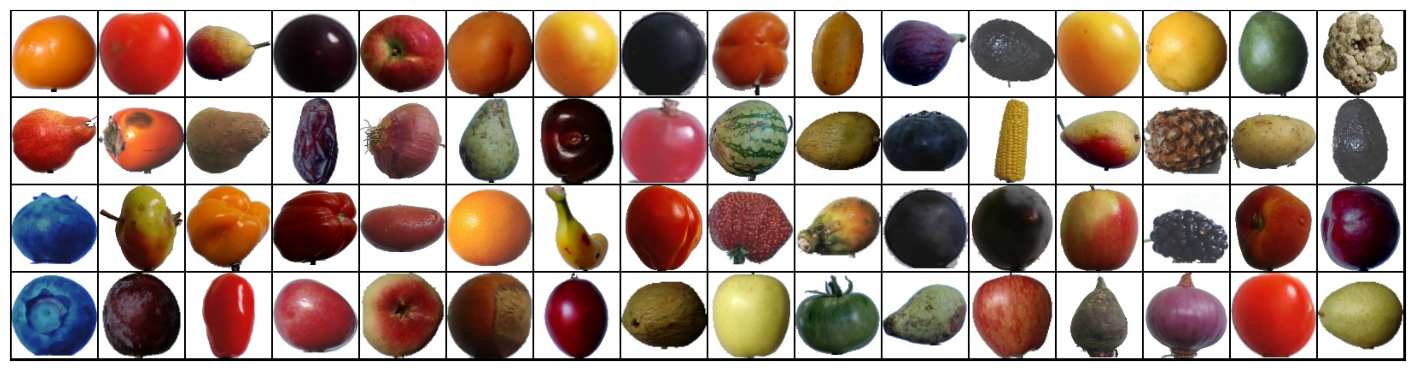

In [13]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

## Convolutional Neural Network

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [15]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(100, 150, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 150 x 16 x 16

            nn.Conv2d(150, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(200, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 200 x 8 x 8

            nn.Conv2d(200, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(250, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 250 x 4 x 4

            nn.Flatten(),
            nn.Linear(36000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(500, 131))

    def forward(self, xb):
        return self.network(xb)

In [17]:
model = CnnModel()
#model.cuda() enable if using nvidia gpu

In [ ]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    #print('out[0]:', out[0])
    break

In [ ]:
#only for gpu training
device = get_default_device()
device

In [ ]:
#only for gpu training
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
# only fro gpu training
model = to_device(CnnModel(), device)

In [ ]:
history=[evaluate(model, val_loader)]
history

In [ ]:
#change length of training
num_epochs = 3
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
#history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func) using gpu
history+= fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

In [ ]:
#history+= fit(num_epochs, lr/10, model, train_dl, val_dl, opt_func) using gpu
history+= fit(num_epochs, lr/10, model, train_loader, val_loader, opt_func)

### Evaluation
We will plot of the losses & accuracies and evaluate the model on the test set.

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()


def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

In [ ]:
plot_accuracies(history)

In [ ]:
plot_losses(history)

In [ ]:
evaluate(model, test_loader)

### Result
- In Convolutional Neural Network accuracy is about 94.98% in 6 epochs on test data.